<a href="https://colab.research.google.com/github/adelaida-suarez-UdeA/EACD-03-BIGDATA/blob/master/06_%5BTALLER%5D_DataFrame%20-%20Adelaida%20Suarez%20-%20Jose%20Herrera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

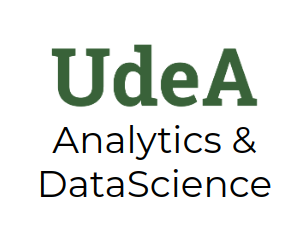

In [66]:
Image("local/imgs/udea-datascience.png")

In [67]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

#SparkContext
import findspark
import re
findspark.init()
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext
#from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf, col, regexp_replace, trim, regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [68]:
import pyspark.sql.functions as F

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# **TALLER 2: DataFrame**
## Desarrollado por: Mg. Efraín Alberto Oviedo; Ing. Kevin Martínez Gallego
## Universidad de Antioquia

Por favor, ingrese la información de cada integrante del grupo de trabajo

**Nombre Completo:**
- Maria Adelaida Suarez Restrepo
- Jose Leonardo Herrera Gutierrez

**Cédula:**
- 1044503458
- 1037645513

**Correo Institucional:**
- adelaida.suarez@udea.edu.co
- jose.herrerag@udea.edu.co

#**Análisis de becas académicas para estudiantes Colombianos**

El ICETEX ha dispuesto un histórico de becas ofrecidas para estudios de nivel de pregrado y posgrado, presenciales o virtuales, que han sido propuestas para fortalecer la formación académica de ciudadanos colombianos en el exterior.

(Disponible en https://www.datos.gov.co/Educaci-n/Icetex-Hist-rico-de-Becas/eb6r-dfgr)

Para cada caso se reportan los siguientes datos:

* Código Convocatoria
* Nombre del Oferente: Nombre del gobierno que ofrece la beca.
* Área del Conocimiento
* Nombre del Programa
* Nombre del País
* Fecha de Recepción -mm/dd/aaaa
* Perfil del Aplicante
* Objetivo del Programa: Breve descripción del programa académico.

Se solicita de su ayuda para responder a los siguientes interrogantes:

In [70]:
schema = StructType() \
    .add("Codigo Convocatoria", IntegerType(), True) \
    .add("Nombre del Oferente", StringType(), True) \
    .add("Area del Conocimiento", StringType(), True) \
    .add("Nombre del Programa", StringType(), True) \
    .add("Nombre del Pais", StringType(), True) \
    .add("Fecha de Recepcion -mm/dd/aaaa", DateType(), True) \
    .add("Perfil del Aplicante", StringType(), True) \
    .add("Objetivo del Programa", StringType(), True)

In [71]:
becasDF = sqlCtx.read.format("csv") \
    .option("header", True) \
    .option("delimiter", ",") \
    .load("/content/local/data/icetex_becas.csv")

In [72]:
print(type(becasDF))

<class 'pyspark.sql.dataframe.DataFrame'>


In [73]:
becasDF.show()

+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|Codigo Convocatoria| Nombre del Oferente|Area del Conocimiento| Nombre del programa|     Nombre del País|Fecha de Recepción -mm/dd/aaaa|Perfil del Aplicante|Objetivo del Programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|          2127916.0|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|PLATAFORMA DE EDU...|          05/27/2016 12:00:...|El programa está ...| a) Proporcionar a...|
|          3101616.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|Chile (República ...|                          null|El programa está ...| El objetivo del P...|
|          2221414.0|GOBIERNO DE LA INDIA|  INGENIERIA Y AFINES|DATA COMMUNICATIO...|India (Rep

In [74]:
becasDF.printSchema()

root
 |-- Codigo Convocatoria: string (nullable = true)
 |-- Nombre del Oferente: string (nullable = true)
 |-- Area del Conocimiento: string (nullable = true)
 |-- Nombre del programa: string (nullable = true)
 |-- Nombre del País: string (nullable = true)
 |-- Fecha de Recepción -mm/dd/aaaa: string (nullable = true)
 |-- Perfil del Aplicante: string (nullable = true)
 |-- Objetivo del Programa: string (nullable = true)



##**A) Calidad de datos**

Revise cada una de las variables disponibles y resuelva los problemas de calidad de datos que puedan afectar el desarrollo de este taller, justificando las razones de su decisión para cada caso


Presente aquí el código desarrollado y el resultado obtenido

In [75]:
# Se convierte la columna Codigo Convocatoria en entero
becasDF = becasDF \
    .withColumn("Codigo Convocatoria", F.col("Codigo Convocatoria").cast(IntegerType()))

# Se eliminan los espacios blancos al inicio y final en las columnas de texto
# para asegurar que el contenido sea estandarizado
becasDF = becasDF \
    .withColumn("Nombre del Oferente", F.trim(F.col("Nombre del Oferente"))) \
    .withColumn("Area del Conocimiento", F.trim(F.col("Area del Conocimiento"))) \
    .withColumn("Nombre del Programa", F.trim(F.col("Nombre del Programa"))) \
    .withColumn("Nombre del País", F.trim(F.col("Nombre del País"))) \
    .withColumn("Perfil del Aplicante", F.trim(F.col("Perfil del Aplicante"))) \
    .withColumn("Objetivo del Programa", F.trim(F.col("Objetivo del Programa")))

# Se ponen en minusculas todas las columnas de texto
becasDF = becasDF \
    .withColumn("Nombre del Oferente", F.lower(F.col("Nombre del Oferente"))) \
    .withColumn("Area del Conocimiento", F.lower(F.col("Area del Conocimiento"))) \
    .withColumn("Nombre del Programa", F.lower(F.col("Nombre del Programa"))) \
    .withColumn("Nombre del País", F.lower(F.col("Nombre del País"))) \
    .withColumn("Perfil del Aplicante", F.lower(F.col("Perfil del Aplicante"))) \
    .withColumn("Objetivo del Programa", F.lower(F.col("Objetivo del Programa")))

# Se reemplazan las tildes

becasDF = becasDF \
    .withColumn("Nombre del Oferente", F.translate("Nombre del Oferente", "áéíóú", "aeiou")) \
    .withColumn("Area del Conocimiento", F.translate("Area del Conocimiento", "áéíóú", "aeiou")) \
    .withColumn("Nombre del Programa", F.translate("Nombre del Programa", "áéíóú", "aeiou")) \
    .withColumn("Nombre del País", F.translate("Nombre del País", "áéíóú", "aeiou")) \
    .withColumn("Perfil del Aplicante", F.translate("Perfil del Aplicante", "áéíóú", "aeiou")) \
    .withColumn("Objetivo del Programa", F.translate("Objetivo del Programa", "áéíóú", "aeiou"))

# Se remueve el caracter '"' en la columna Perfil del Aplicante

becasDF = becasDF \
    .withColumn("Perfil del Aplicante", F.regexp_replace(F.col("Perfil del Aplicante"), '"', ''))

# Se convierte la columna Fecha de Recepcion -mm/dd/aaaa a formato de fecha

becasDF = becasDF \
    .withColumn("Fecha de Recepción -mm/dd/aaaa", F.to_timestamp(F.col("Fecha de Recepción -mm/dd/aaaa"), 'MM/dd/yyyy hh:mm:ss a'))


In [76]:
# Mostrar las filas duplicadas

becasDF.exceptAll(becasDF.dropDuplicates()).show()

+-------------------+-------------------+---------------------+-------------------+---------------+------------------------------+--------------------+---------------------+
|Codigo Convocatoria|Nombre del Oferente|Area del Conocimiento|Nombre del Programa|Nombre del País|Fecha de Recepción -mm/dd/aaaa|Perfil del Aplicante|Objetivo del Programa|
+-------------------+-------------------+---------------------+-------------------+---------------+------------------------------+--------------------+---------------------+
+-------------------+-------------------+---------------------+-------------------+---------------+------------------------------+--------------------+---------------------+



In [77]:
# Mostrar los registros con null

becasDF.exceptAll(becasDF.na.drop()).show()

+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|Codigo Convocatoria| Nombre del Oferente|Area del Conocimiento| Nombre del Programa|     Nombre del País|Fecha de Recepción -mm/dd/aaaa|Perfil del Aplicante|Objetivo del Programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|            6200212|gobierno de indon...|     diferentes areas|maestria en difer...|indonesia (republ...|                          null|el programa esta ...| con el fin de est...|
|            2211413|gobierno de la india|          humanidades|certificate cours...|india (republica ...|                          null|el programa curso...| brindar a los par...|
|            2102115|  gobierno de egipto| ciencias agropecu...|tecnologia de pro...|egipto (re

In [78]:
becasDF.show()

+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|Codigo Convocatoria| Nombre del Oferente|Area del Conocimiento| Nombre del Programa|     Nombre del País|Fecha de Recepción -mm/dd/aaaa|Perfil del Aplicante|Objetivo del Programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|            2127916|oea - top - argen...|       administracion|politicas de gobi...|plataforma de edu...|           2016-05-27 00:00:00|el programa esta ...| a) proporcionar a...|
|            3101616|alianza del pacif...|     diferentes areas|plataforma de mov...|chile (republica ...|                          null|el programa esta ...| el objetivo del p...|
|            2221414|gobierno de la india|  ingenieria y afines|data communicatio...|india (rep

##**B) Aumento de ofertas de becas**

Identifique si la cantidad de becas ofrecidas para ciudadanos colombianos se ha incrementado con los años

In [79]:
becasYearDF = becasDF.groupBy(F.year("Fecha de Recepción -mm/dd/aaaa").alias("year")).count().orderBy("year")

In [80]:
becasYearDF.show()

+----+-----+
|year|count|
+----+-----+
|null|  647|
|2011|  126|
|2012|  135|
|2013|  121|
|2014|  165|
|2015|  114|
|2016|  177|
+----+-----+



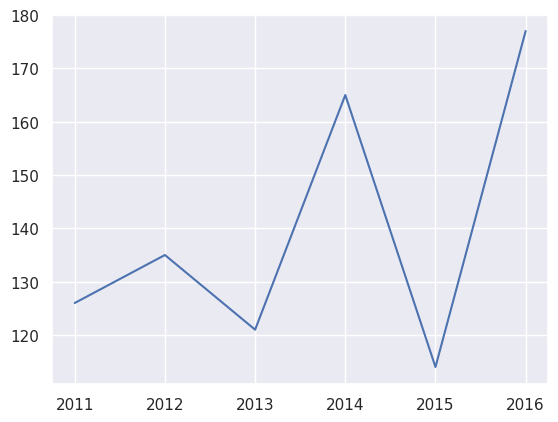

In [81]:
plt.plot(becasYearDF.select("year").collect(), becasYearDF.select("count").collect())

##**C) Paises que han ofrecido becas**

Presente un listado con todos los países (diferentes de Colombia) de los que se tiene reporte que han ofrecido becas para estudiantes colombianos (*solamente presentar nombres de países, y estos solo deben aparecer una única vez en la lista*)

In [97]:
becasDF.registerTempTable("Becas")

In [98]:
becasDF = becasDF.withColumn(
    "Nombre del País",
    regexp_replace("Nombre del País", r"\s*\(.*?\)", "")
)

In [105]:
distinct_countries = sqlCtx.sql("""
    SELECT DISTINCT(`Nombre del País`)
    FROM Becas
    WHERE `Nombre del País` NOT LIKE '%colombia%'
    AND `Nombre del País` NOT LIKE '%plataforma%'
    AND `Nombre del País` NOT LIKE '%diferentes%'
    ORDER BY `Nombre del País` ASC
    """).collect()

In [106]:
distinct_countries_list = [r['Nombre del País'] for r in distinct_countries]

In [107]:
distinct_countries_list

['argentina',
 'australia',
 'barbados jamaica & trinidad y tobago',
 'belgica',
 'belice',
 'brasil',
 'brunei',
 'canada',
 'checa rep.',
 'chile',
 'china',
 'corea del sur',
 'costa rica',
 'ecuador',
 'egipto',
 'españa',
 'estados unidos',
 'estados unidos mexicanos españa y alemania',
 'estados unidos reino unido emiratos arabes china.',
 'francia',
 'honduras',
 'hungria',
 'india',
 'indonesia',
 'israel',
 'italia',
 'japon',
 'malasia',
 'mexico',
 'nicaragua',
 'nueva zelanda',
 'panama',
 'paraguay',
 'peru',
 'polonia',
 'puerto rico',
 'reino unido',
 'rusia',
 'singapur',
 'suecia',
 'suiza',
 'tailandia',
 'taiwan',
 'trinidad y tobago',
 'turquia',
 'uruguay']

##**D) Áreas del conocimiento y Posgrados**

Se desea averiguar cúal es el área de conocimiento predominante por país. Además, queremos conocer qué porcentaje de los programas ofrecidos (**de acuerdo al nombre del programa**) corresponden a estudios de posgrado.

In [121]:
def checkPostgraduate(program):
  '''
  Verifica si el programa es de posgrado

  Args:
    program: Nombre del programa

  Returns:
    1 si el programa es de posgrado, 0 en caso contrario
  '''
  if any(w in program for w in ["posgrado", "especializacion", 'maestria']):
    return 1
  else:
    return 0

sqlCtx.registerFunction("checkPostgraduate", checkPostgraduate)

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/context.py:283: FutureWarning: Deprecated in 2.3.0. Use spark.udf.register instead.
  warnings.warn("Deprecated in 2.3.0. Use spark.udf.register instead.", FutureWarning)


<function __main__.checkPostgraduate(program)>

In [122]:
sqlCtx.sql("""
SELECT AVG(checkPostgraduate(`Nombre del Programa`)) AS `Posgrado`
FROM Becas
""").show()

+-------------------+
|           Posgrado|
+-------------------+
|0.19528619528619529|
+-------------------+



In [119]:
area_by_country = (becasDF.filter(~col("Nombre del País").like("%plataforma%"))
.groupBy("Nombre del País")
.agg(F.mode("Area del Conocimiento").alias("Area Más Frecuente"))
.orderBy("Nombre del País"))

In [120]:
area_by_country.show(200)

+--------------------+--------------------+
|     Nombre del País|  Area Más Frecuente|
+--------------------+--------------------+
|           argentina|      administracion|
|           australia|maestrias en dife...|
|barbados jamaica ...|ciencias de la ed...|
|             belgica| ingenieria y afines|
|              belice|         humanidades|
|              brasil|pregrado en difer...|
|              brunei|maestrias y docto...|
|              canada|maestrias y docto...|
|          checa rep.|         humanidades|
|               chile|    diferentes areas|
|               china|posgrado diferent...|
|            colombia|ciencias naturale...|
|       corea del sur|administracion - ...|
|          costa rica|      administracion|
|   diferentes paises|posgrado diferent...|
|             ecuador|    diferentes areas|
|              egipto|ciencias agropecu...|
|              españa|      administracion|
|      estados unidos| ingenieria y afines|
|estados unidos me...|    difere

##**E) ¿Qué podemos concluir a partir del Perfil del Aspirante y el Objetivo del Programa?**

Se dispone de dos campos de descripción, que no emplean un formato claro que permita analizar los perfiles de los aspirantes con respecto al objetivo del programa.

Plantee una forma de analizar esta información para conocer las relaciones entre los perfiles y lo objetivos.

Presente aquí el código desarrollado y el resultado obtenido

In [153]:
# Lista de stopwords
nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(stopwords.words('spanish'))
stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [151]:
# UDF para eliminación de ruido, tokenización y limpieza
def clean_and_tokenize(text):
    if text is None:
        return []

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar URLs, caracteres especiales y números
    text = re.sub(r"http\S+|www\.\S+|indexphp\S+", "", text)  # URLs
    text = re.sub(r"[^a-záéíóúñ\s]", "", text)  # Caracteres especiales y números

    # Tokenización (separar palabras) y eliminación de espacios múltiples
    tokens = re.split(r"\s+", text.strip())

    # Quitar stopwords y palabras vacías
    tokens = [word for word in tokens if word not in stopwords and word.strip() != ""]

    return tokens

# Registrar UDF
clean_and_tokenize_udf = udf(clean_and_tokenize, ArrayType(StringType()))

# Aplicar el UDF para limpiar y tokenizar
becasDF_cleaned = (
    becasDF
    .withColumn(
        "Perfil Tokens",
        clean_and_tokenize_udf(col("Perfil del Aplicante"))
    )
)

# Mostrar resultados
becasDF_cleaned.select("Perfil del Aplicante", "Perfil Tokens").show(truncate=False)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


AttributeError: 'set' object has no attribute 'words'

##**Análisis de los resultados**

Teniendo en cuenta los resultados obtenidos en los puntos anteriores, presente sus impresiones sobre las becas académicas disponibles para los estudiantes colombianos.


#**Notas:**

* Analice los resultados de cada punto y presente sus conclusiones
* Utilice al menos una vez cada uno de los siguientes métodos

  *   agg
  *   withColumn
  *   groupBy
  *   sql
  *   registerFunction